## Symbols extracting funcions

In [6]:
import cv2
import os
import math
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def display_plot(image, title='', cmap=None):
    plt.figure(figsize=(15,7))
    plt.imshow(image,cmap=cmap)
    plt.title(title)
    plt.show()

In [8]:
def contains(box1,box2):
    b1x,b1y,b1w,b1h=box1
    b2x,b2y,b2w,b2h=box2
    return b1x<b2x and b1y<b2y and (b1x+b1w)>(b2x+b2w) and (b1y+b1h)>(b2y+b2h)

In [23]:
def process_img(org_img, display=False):
    img = org_img.copy()
    if display:
        display_plot(img,'Original image',None)


    #Convert to grayscale and denoise
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.fastNlMeansDenoising(img,h=13)
    if display:
        display_plot(img,'Grayscale and denoised','gray')

    #Binarize image
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,19,2)
    if display:
        display_plot(img,'With binary threshold applied','gray')
        
    #Morphological opening
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN,  np.ones((5,5),np.uint8))
    if display:
        display_plot(img,'With Morphological opening','gray')
    img_binary = img.copy()
        
    #Find contours
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = cv2.drawContours(img, contours, -1, (0,255,0), 3)
    if display:
        display_plot(img_contours, 'Contours' , 'gray')
    
    #Add limit to bounding boxes size
    img_size = img.shape[0]*img.shape[1]
    max_area=0.5*img_size

    #Find bounding boxes
    boxes=[]
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if max_area>(w*h):
            boxes.append((x,y,w,h))
    
    #Remove boxes wholly contained in other boxes
    for box1 in boxes.copy():
        for box2 in boxes.copy():
            if contains(box2,box1):
                if box1 in boxes:
                    boxes.remove(box1)
    
    #sort boxes horizontally
    boxes = sorted(boxes, key=lambda b: b[0])
    
    img_boxes = org_img.copy()
    for box in boxes:
        x,y,w,h=box
        cv2.rectangle(img_boxes,(x,y),(x+w,y+h),(0,255,0),2)
    if display:
        display_plot(img_boxes,'Bounding boxes', 'gray')
        
    return img_boxes, img_binary, boxes

In [22]:
def extract_symbols(img, boxes, size=28):
    symbols=[]
    for box in boxes:
        x,y,w,h=box
        symbol = img[y:y+h,x:x+w]
        if h>=w:
            newx = size*w//h
            if newx == 0:
                break
            symbol = cv2.resize(symbol,(newx,size))
            rest = size-newx
            rest_left = int(math.ceil(rest/2))
            rest_right = int(math.floor(rest/2))
            symbol = np.hstack((np.full((size,rest_left),255),symbol,np.full((size,rest_right),255)))
        else:
            newy = size*h//w
            if newy == 0:
                break
            symbol = cv2.resize(symbol,(size,newy))
            rest = size-newy
            rest_up = int(math.ceil(rest/2))
            rest_down = int(math.floor(rest/2))
            symbol = np.vstack((np.full((rest_up,size),255),symbol,np.full((rest_down,size),255)))
        symbols.append(symbol)
    return symbols

## Test single image

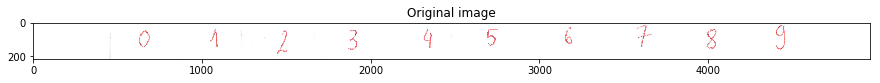

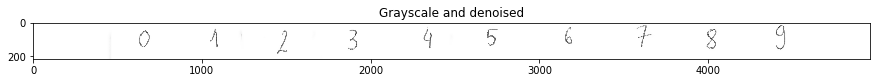

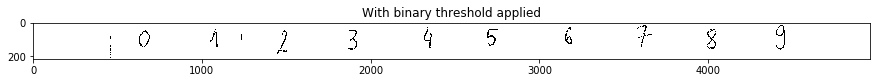

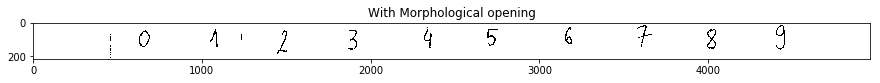

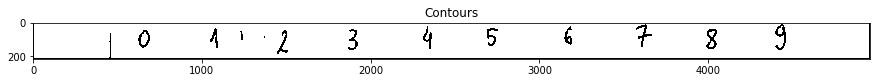

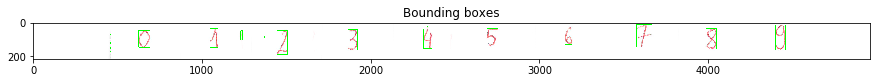

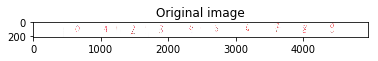

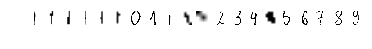

In [8]:
img = cv2.imread('equations/a.jpg')
    img_boxes,img_binary,boxes = process_img(img, True)
    symbols = extract_symbols(img_binary,boxes)

plt.imshow(img)
plt.title('Original image')
plt.show()

for i,symbol in enumerate(symbols):
    plt.subplot(1, len(symbols), i+1)
    plt.axis('off')
    plt.imshow(symbol,cmap='gray')
plt.show()

## Tests for whole set

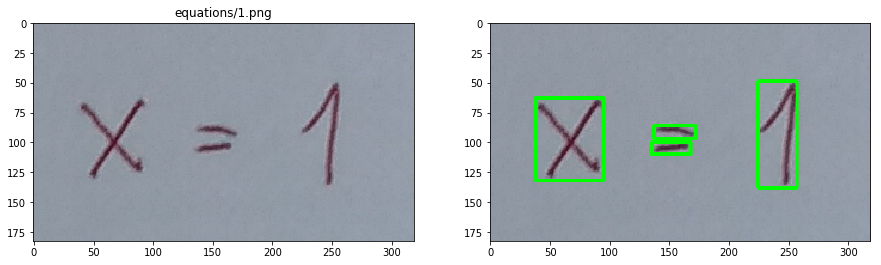

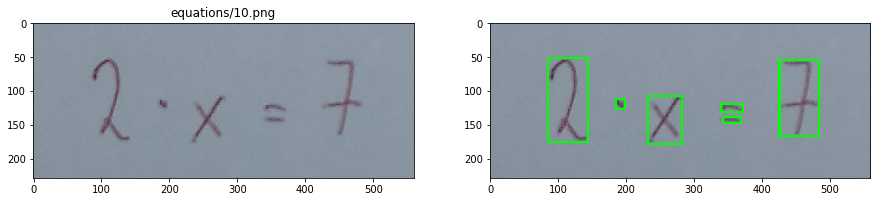

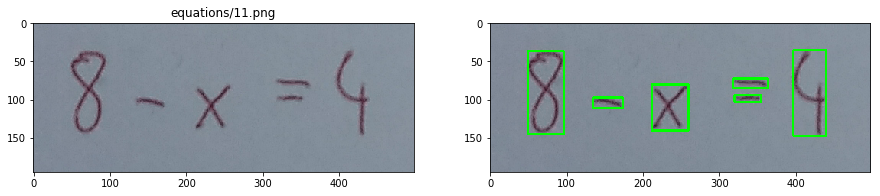

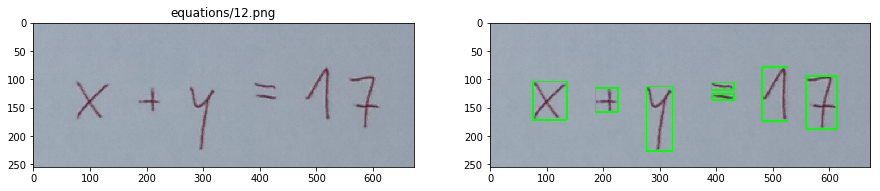

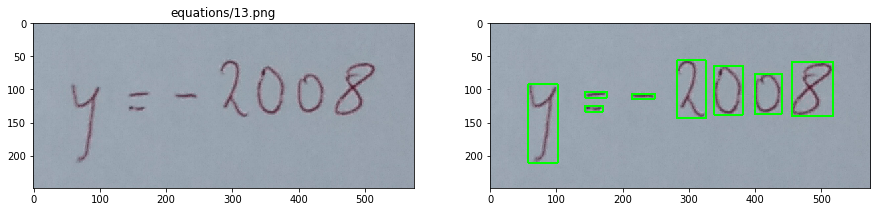

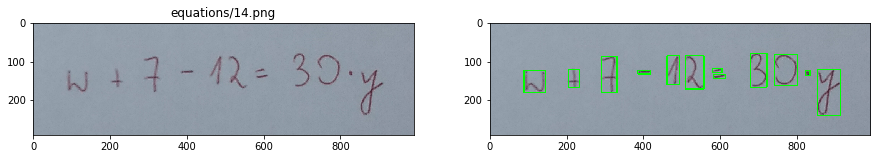

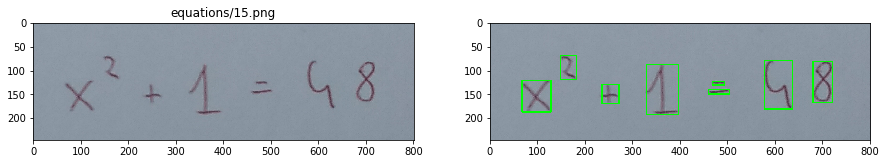

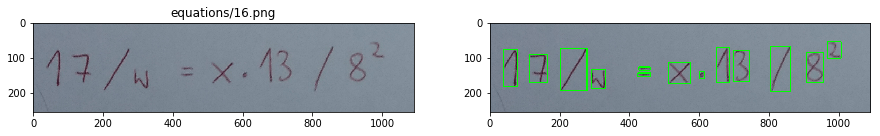

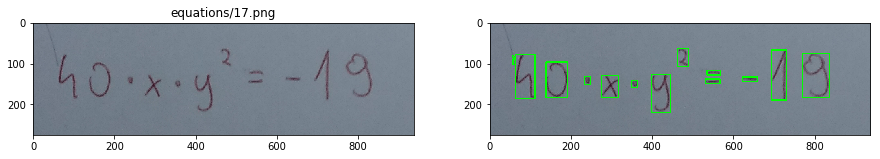

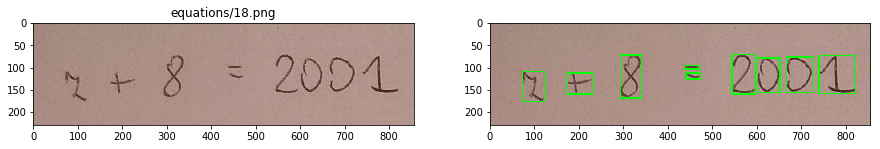

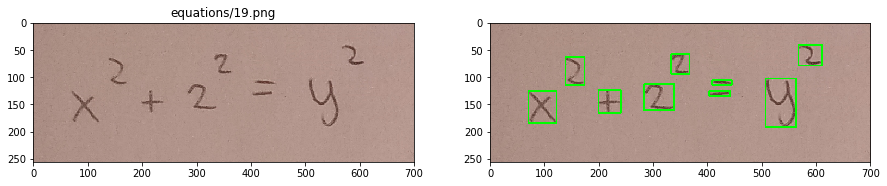

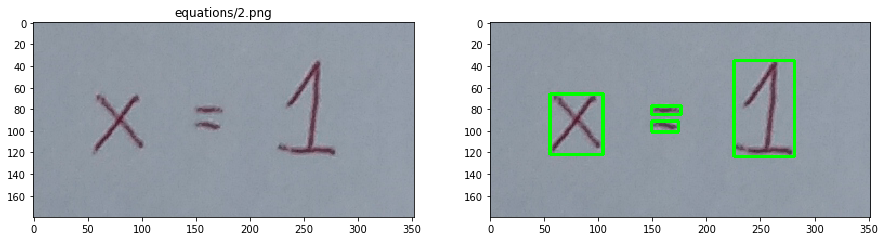

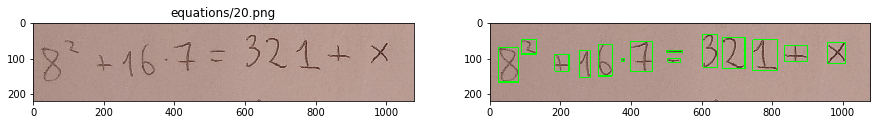

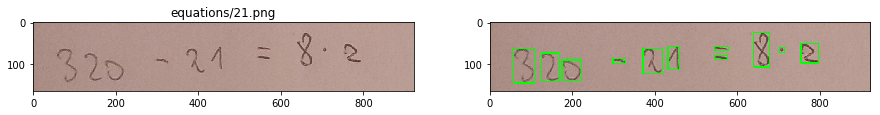

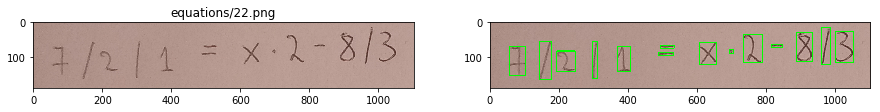

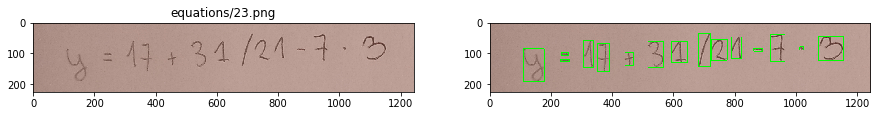

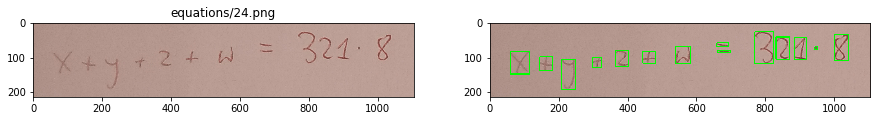

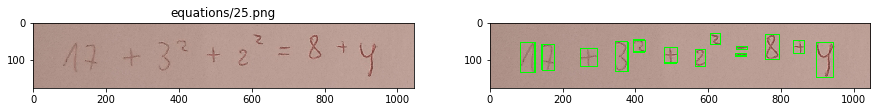

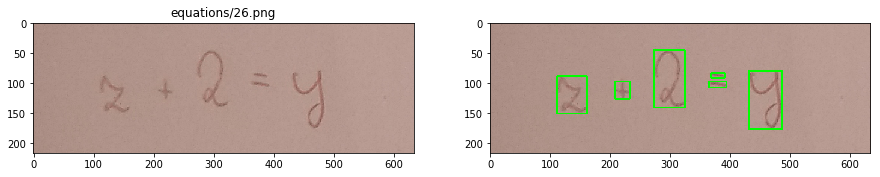

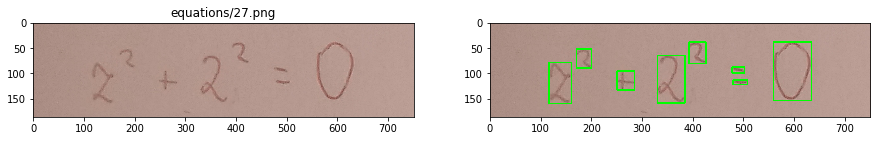

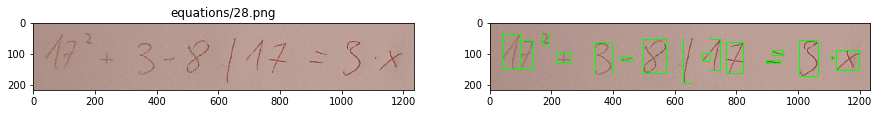

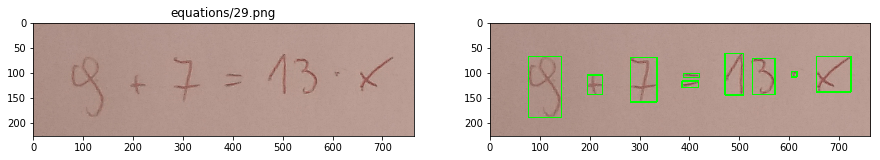

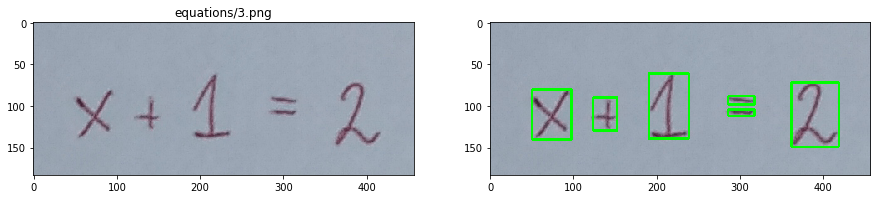

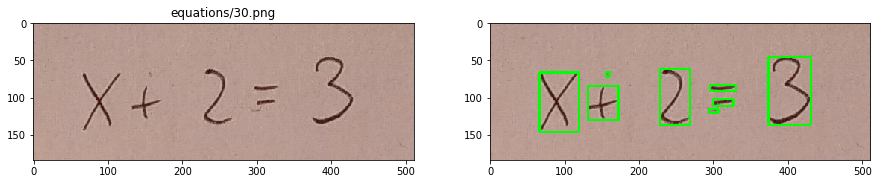

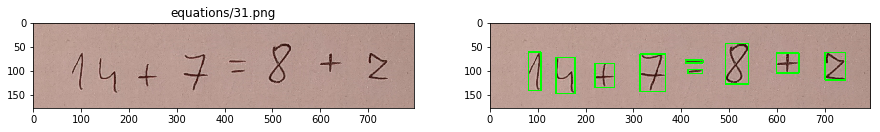

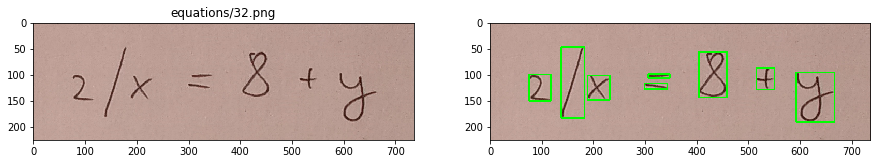

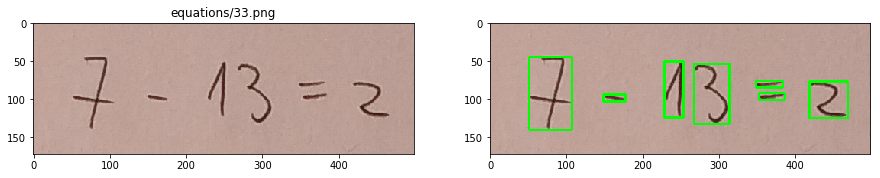

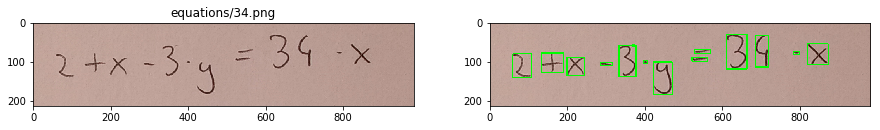

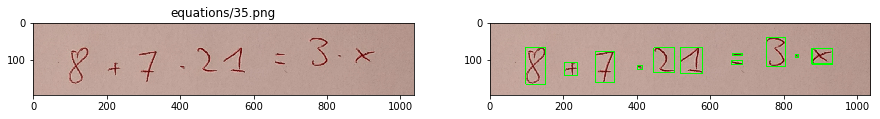

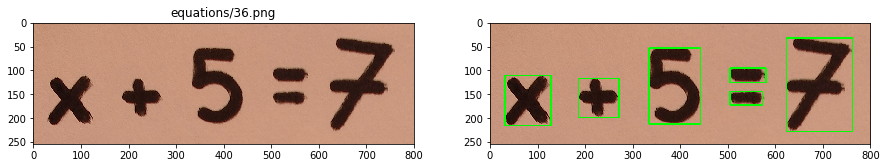

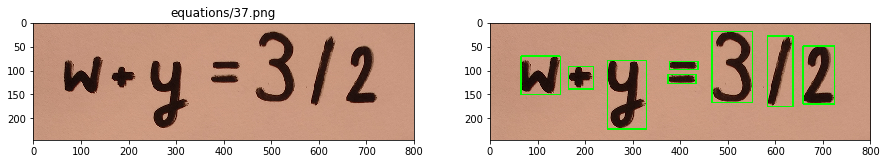

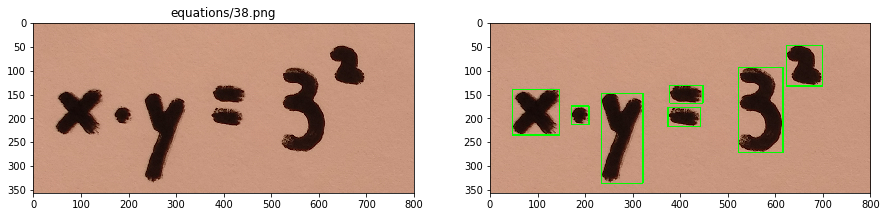

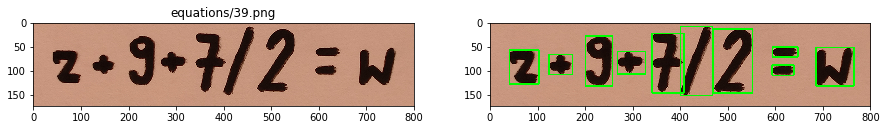

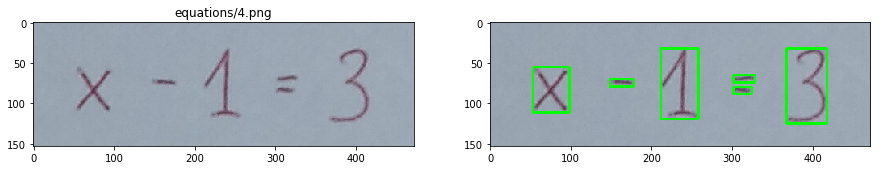

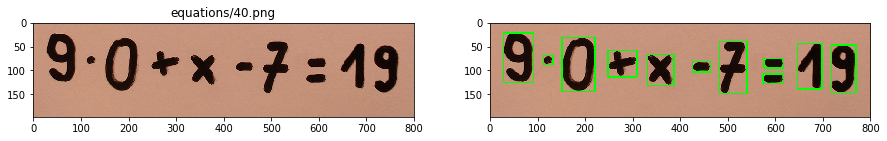

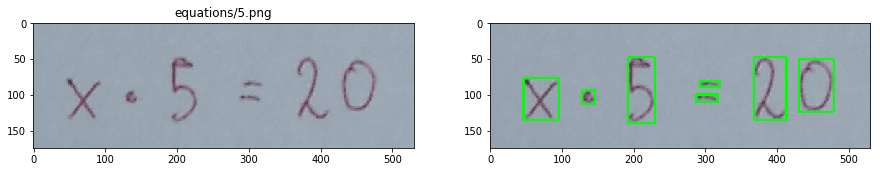

c:\users\wojciech\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


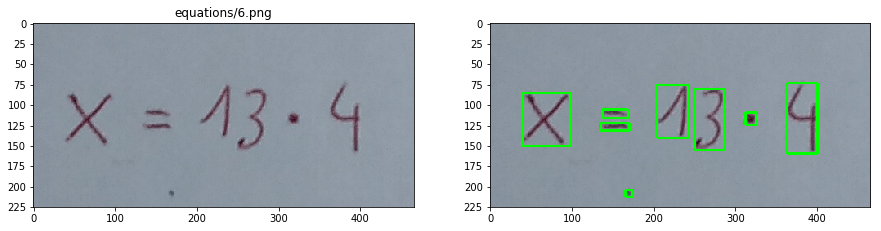

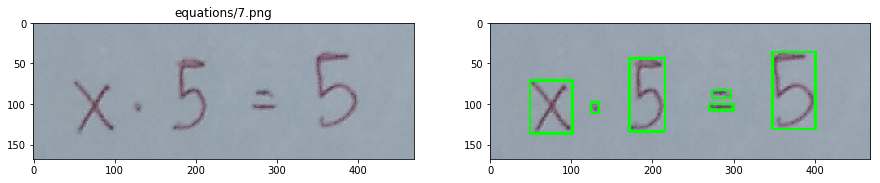

KeyboardInterrupt: 

In [21]:
#Tests for whole set
DIR = 'equations'
for file in os.listdir(DIR):
    file=f'{DIR}/{file}'
    img = cv2.imread(file)
    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(file)
    img_boxes, img_binary, boxes = process_img(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_boxes, cmap='gray')
    plt.show()

## Create intermediate imgs from swilk dataset

In [ ]:
DIR = 'TP-data' #Input directory
INT_DIR='intermediate' #Output directory
locations={
    'z':(5505,260,2550,300),
    'y':(5505,265,2150,300),
    'x':(5490,260,1730,300),
    'w':(5490,260,1280,300),
    'minus':(2620,200,1740,300),
    'plus':(2620,240,1320,300),
    'dot':(2620,180,500,300),
    '9':(2015,270,4250,280),
    '8':(2015,250,3880,280),
    '7':(2015,250,3450,280),
    '6':(2025,250,3000,280),
    '5':(2015,270,2580,280),
    '4':(2005,270,2150,280),
    '3':(2005,270,1740,280),
    '2':(2015,245,1320,300),
    '1':(2015,255,890,300),
    '0':(2015,255,500,300)
}
for file_name in os.listdir(DIR):
    file=f'{DIR}/{file_name}'
    img = cv2.imread(file)
    for symbol, loc in locations.items():
        y,h,x,w=loc
        sym_img=img[y:y+h,x:x+w]
        cv2.imwrite(f'{INT_DIR}/{symbol}-{file_name}.png',sym_img)

## Exract symbols based on previous steps. Manual removal of some garbage output may be necessary

In [ ]:
DIR = 'intermediate' #Input directory
OUT_DIR ='final' #Output directory

symbols_count_map={}

for file_name in os.listdir(DIR):
    symbol_name=file_name.split('-')[0]
    file=f'{DIR}/{file_name}'
    img=cv2.imread(file)
    img_boxes,img_binary,boxes = process_img(img)
    symbols = extract_symbols(img_binary,boxes)
    for symbol in symbols:
        count = symbols_count_map.get(symbol_name,0)
        cv2.imwrite(f'{OUT_DIR}/{symbol_name}-{count}.png',symbol)
        symbols_count_map[symbol_name]=count+1
        